数据集的结构类型: <class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>
数据集的样本数: 60000
一次迭代使用的样本数: 1
数据集字典项: ['image', 'label']
图片Tensor的形状: (28, 28, 1)
图片的标签: 8


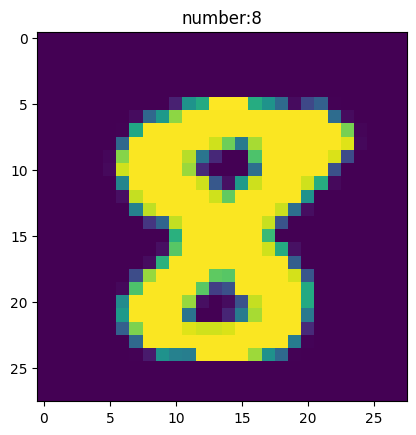

.....................................................................................
每批处理数据数: 32
数据集的批次数: 1875
图像Tensor形状: (32, 1, 32, 32)
标签: [3 0 6 6 8 1 2 7 2 8 5 3 7 7 2 1 2 9 6 2 7 8 0 2 1 9 3 5 8 2 9 7]


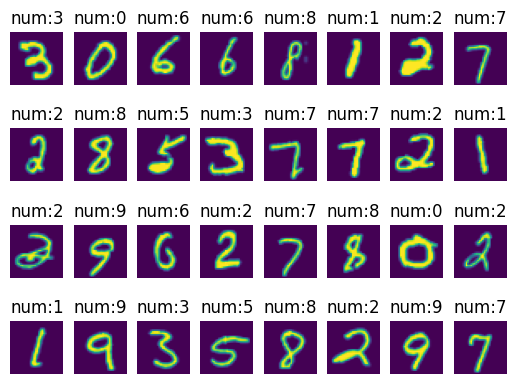

.....................................................................................
LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
  (fc1): Dense<input_channels=400, output_channels=120, has_bias=True>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (fc3): Dense<input_channels=84, output_channels=10, has_bias=True>
  (relu): ReLU<>
  (max_pool2d): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  >
epoch: 1 step: 125, loss is 2.293308734893799
epoch: 1 step: 250, loss is 2.301149606704712
epoch: 1 step: 375, loss is 2.3050005435943604
epoch: 1 step: 500, loss is

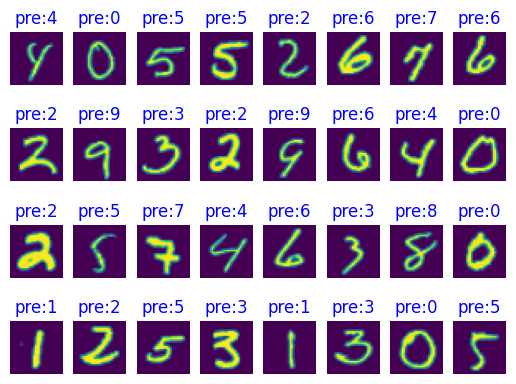

In [1]:
from mindspore import context

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import mindspore.dataset as ds

train_data_path = "DataSet_MNIST/train"  #训练数据集路径
test_data_path = "DataSet_MNIST/test"    #测试数据集路径

'''
第一步查看数据集中的数据
'''

mnist_ds = ds.MnistDataset(train_data_path)  
#读取和解析 MNIST 数据集的源文件构建数据集
#生成的图像有两列 [img, label] , image 列的数据类型为uint8，label 列的数据类型为uint32
#因为像素点的取值范围是(0, 255),需要注意的是这两列数据的数据类型是 Tensor

print('数据集的结构类型:', type(mnist_ds))
print("数据集的样本数:", mnist_ds.get_dataset_size())   #获取数据集的大小
print("一次迭代使用的样本数:",mnist_ds.get_batch_size())    #一个迭代使用的样本数

dic_ds = mnist_ds.create_dict_iterator()    #数据集上创建迭代器，为字典数据类型，输出的为Tensor类型
item = next(dic_ds)
img = item["image"].asnumpy()   #asnumpy为 Tensor 中的方法，功能是将张量转化为numpy数组，因为matplotlib.pyplot中不接受Tensor数据类型的参数
label = item["label"].asnumpy()

print("数据集字典项:", list(item.keys()))
print("图片Tensor的形状:", img.shape)   #图片数据类型的形状
print("图片的标签:", label)    #图片标签

plt.imshow(np.squeeze(img))    #squeeze将shape中为1的维度去掉，plt.imshow()函数绘制热图显示图像
plt.title("number:%s"% item["label"].asnumpy())
plt.show()  #show显示图像
print('.....................................................................................')


'''
第二步对原始数据集进行处理
'''

import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype

def create_dataset(data_path, batch_size=32, repeat_size=1, num_parallel_workers=1):
    '''
    :param data_path:训练集路径
    :param batch_size:一批次数据量
    :param repeat_size:重复数据集的次数
    :param num_parallel_workers:指定map操作的多进程/多线程并发数，加快处理速度
    :return:返回经过处理后的数据集
    '''
    
    mnist_ds = ds.MnistDataset(data_path)

    # 定义数据增强和处理所需的一些参数
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # 根据上面所定义的参数生成对应的数据增强方法，即实例化对象
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)  #以线性插值的方式调整图像尺寸
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)  #基于给定的缩放和平移因子调整图像的像素大小
    rescale_op = CV.Rescale(rescale, shift)  #基于给定的缩放和平移因子调整图像的像素大小
    hwc2chw_op = CV.HWC2CHW()  #将输入图像的shape从 <H, W, C> 转换为 <C, H, W>
    type_cast_op = C.TypeCast(mstype.int32)  #将输入的 Tensor 转换为指定的数据类型

    # 将数据增强处理方法映射到在对应数据集的相应部分（image，label）
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)

    # 处理生成的数据集
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)  #混洗数据集的行,返回混洗后的数据集
    #将数据集中连续 batch_size 条数据合并为一个批处理数据
    #其中当最后一个批处理数据包含的数据条目小于 batch_size 时，将该批处理丢弃
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)  
    mnist_ds = mnist_ds.repeat(repeat_size)  #重复此数据集 repeat_size 次

    return mnist_ds

ms_dataset = create_dataset(train_data_path)


'''
第三步查看处理后数据集中的第一批数据
'''

print('每批处理数据数:',ms_dataset.get_batch_size())   #每一组的数量
print('数据集的批次数:', ms_dataset.get_dataset_size())  #数据集的组数

data = next(ms_dataset.create_dict_iterator(output_numpy=True))  #创建迭代器   
images = data["image"]
labels = data["label"]
print('图像Tensor形状:', images.shape)
print('标签:', labels)

count = 1
for i in images:
    plt.subplot(4, 8, count)
    plt.imshow(np.squeeze(i))
    plt.title('num:%s'%labels[count-1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()
print('.....................................................................................')


'''
第四步构建卷积神经网络
'''
import mindspore.nn as nn
from mindspore.common.initializer import Normal

class LeNet5(nn.Cell):
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()  #继承父类nn.cell的__init__方法
        
        
        #nn.Conv2d的第一个参数是输入图片的通道数，即单个过滤器应有的通道数;
        #第二个参数是输出图片的通道数,即过滤器的个数;
        #第三个参数是过滤器的二维属性，它可以是一个int元组，但由于一般过滤器都是a x a形式的，而且为奇数。
        #所以这里填入单个数即可,参数pad_mode为卷积方式，valid卷积即padding为0的卷积
        #现在也比较流行same卷积，即卷积后输出的图片不会缩小。需要注意的是卷积层我们是不需要设置参数的随机方式的，因为它默认会给我们选择为Normal。
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        
        
        #nn.Dense为致密连接层，它的第一个参数为输入层的维度，第二个参数为输出的维度，第三个参数为神经网络可训练参数W权重矩阵的初始化方式，默认为normal
        #Normal()生成一个服从正态分布 N(sigma,mean) 的随机数组用于初始化Tensor
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        
        #nn.ReLU()非线性激活函数，它往往比论文中的sigmoid激活函数具有更好的效益
        self.relu = nn.ReLU()
        #nn.MaxPool2d为最大池化层的定义，kernel_size为采样器的大小，stride为采样步长，本例中将其
        #都设置为2相当于将图片的宽度和高度都缩小一半
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        #nn.Flatten为输入展成平图层，即去掉那些空的维度
        self.flatten = nn.Flatten()

    def construct(self, x):
        
       #输入x，下面即是将x通过LeNet5网络执行前向传播的过程
        x = self.max_pool2d(self.relu(self.conv1(x)))
        x = self.max_pool2d(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
print(LeNet5())   #查看LeNet-5的各层网络参数

from mindspore.nn import SoftmaxCrossEntropyWithLogits

lr = 0.01   #learingrate,学习率，可以使梯度下降的幅度变小，从而可以更好的训练参数
momentum = 0.9
network = LeNet5()

#使用了流行的Momentum优化器进行优化
#vt+1=vt∗u+gradients
#pt+1=pt−(grad∗lr+vt+1∗u∗lr)
#pt+1=pt−lr∗vt+1
#其中grad、lr、p、v和u分别表示梯度、学习率、参数、力矩和动量。
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)

#相当于softmax分类器
#sparse指定标签（label）是否使用稀疏模式，默认为false,reduction为损失的减少类型：mean表示平均值，一般
#情况下都是选择平均地减少
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


from mindspore.train.callback import Callback

class StepLossAccInfo(Callback):  # custom callback function
    def __init__(self, model, eval_dataset, steps_loss, steps_eval):
        self.model = model  #计算图模型Model
        self.eval_dataset = eval_dataset   #测试数据集
        self.steps_loss = steps_loss
        #收集step和loss值之间的关系，数据格式{"step": [], "loss_value": []}，会在后面定义
        self.steps_eval = steps_eval
        #收集step对应模型精度值accuracy的信息，数据格式为{"step": [], "acc": []}，会在后面定义

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        #cur_epoch_num是CallbackParam中的定义，获得当前处于第几个epoch,一个epoch意味着训练集
        #中每一个样本都训练了一次
        cur_epoch = cb_params.cur_epoch_num
        
        #同理，cur_step_num是CallbackParam中的定义，获得当前执行到多少step
        cur_step = (cur_epoch-1)*1875 + cb_params.cur_step_num
        self.steps_loss["loss_value"].append(str(cb_params.net_outputs))
        self.steps_loss["step"].append(str(cur_step))
        if cur_step % 125 == 0:
            #调用model.eval返回测试数据集下模型的损失值和度量值，dic对象
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])


from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.nn import Accuracy
from mindspore import Model

epoch_size = 1  #每个epoch需要遍历完成图片的batch数,这里是只要遍历一次
model_path = "models/ckpt/mindspore_quick_start/"
eval_dataset = create_dataset(test_data_path)
#调用Model高级API，将LeNet-5网络与损失函数和优化器连接到一起，具有训练和推理功能的对象。
#metrics 参数是指训练和测试期，模型要评估的一组度量，这里设置的是"Accuracy"准确度
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()} )

#保存训练好的模型参数的路径
config_ck = CheckpointConfig(save_checkpoint_steps=375, keep_checkpoint_max=16)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", directory=model_path, config=config_ck)

#回调类中提到的我们要声明的数据格式
steps_loss = {"step": [], "loss_value": []}
steps_eval = {"step": [], "acc": []}
#使用model等对象实例化StepLossAccInfo，得到具体的对象
step_loss_acc_info = StepLossAccInfo(model , eval_dataset, steps_loss, steps_eval)

#调用Model类的train方法进行训练，LossMonitor(125)每隔125个step打印训练过程中的loss值,dataset_sink_mode为设置数据下沉模式，但该模式不支持CPU，所以这里我们只能设置为False
model.train(epoch_size, ms_dataset, callbacks=[ckpoint_cb, LossMonitor(125), step_loss_acc_info], dataset_sink_mode=False)
print('.....................................................................................')


'''
第五步测试并可视化
'''

import mindspore as ms

def test_net(network, model, mnist_path):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = ms.load_checkpoint("models/ckpt/mindspore_quick_start/checkpoint_lenet-1_1875.ckpt")
    # load parameter to the network
    ms.load_param_into_net(network, param_dict)
    # load testing dataset

    acc = model.eval(eval_dataset, dataset_sink_mode=False)
    print("============== Accuracy:{} ==============".format(acc))

test_net(network, model, test_data_path)

ds_test = eval_dataset.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

output = model.predict(ms.Tensor(data['image']))   
#利用加载好的模型的predict进行预测，注意返回的是对应的（0到9）的概率
pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i+1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i/8)+1, i%8+1, pred[i], labels[i]), '\n')
if index:
    print("All the figures in this group are predicted correctly!")
print(pred, "<--Predicted figures")
print(labels, "<--The right number")
plt.show()